# Lead screw dimensioning 
We have to investigate if the lead screw will fail under the expexted load. For this, the following studies are carried out : 
* Bucking strength 
* Compression strength 
* Thread strength 

The goal is to determine the diameter of the screw and the thread characteristics.  

### Thread and material specs
The characteristic diameters of the screw are considered to be equal to the mean of the tolerance range specified by DIN 103. 


In [4]:
import numpy as np 
import matplotlib.pyplot as plt 

# Material data 
E  = 210  # modulus of elasticity  [GPa] -- for stainless steel 
sigma_comp_max = 400 # compressive strength in [MPa] 
P_max = 5 # max surface pressure in N/ mm^2 
# pv_factor = 200 # in [N/mm^2 * m/min]

screw_length = 2500 # refers to the free length of the screw -- in [mm]
pitch = 5
starts = 8  
lead = pitch * starts  # in [mm /rev]

D_minor = (18.42 + 19.00)/2 # aka screw root diameter in [mm]
D_major = (23.67 + 24.00)/2 # screw outer diameter in [mm] -- we can cosider this as the shaft diameter given in the datasheet
D_pitch = (20.79 + 21.39)/2 # aka flank diameter -- screw pitch diameter  in [mm]

# linear accuracy 
accuracy_rot = np.deg2rad(1.8)/2/np.pi # motor accuracy converted to [rev] 
accuracy_lin = lead * accuracy_rot 
print("Feed accuracy is %lf mm"%accuracy_lin)

Feed accuracy is 0.200000 mm


## Required rotational speed and critical speed 
From the maximum linear velocity of the actuators, calculate the maximum rotational velocity of the screw. This will be compared with the limit due to surface presssure and also be used for motor dimensioning and selection. 
Actuator velocities have been calculated for the stress trajectory in the `stress_test.ipynb` notebook.   

The screw has to be operated at 80% of its resonant frequency. For this purpose, the critial speed it calculated. This mostly dependant of the screw geometry and the end fixity. The formula for calculating the critical speed was found from a lead sscrew manufacturer's [website](https://www.helixlinear.com/blog/lead-screws/working-with-critical-speeds-and-lead-screws/). This formula includes estimations, so it is used for quick checks, and when the proper screw characteritic have been found, then the screw can also be checked with the manufacturer's diagrams. 

In [7]:
# Max required rotational speed for the stress trajectory
actuator__velocities = np.genfromtxt("../kinematics/analytical_equations/results/actuator_velocities.csv", delimiter = ",")
max_velocities = np.array([abs(actuator__velocities)[:,0].max(), abs(actuator__velocities)[:,1].max(),abs(actuator__velocities)[:,2].max()])
feed_required = max_velocities.max()* 60  # in m/min 
omega_required = feed_required * 1000 /lead # *1000 because all other specs are in mm -- in [rpm]
print("Required feed : %lf [m/sec]"%(feed_required/60))                                                                                                                                                     
print("Required rotational speed : %lf [rpm]"%omega_required)

# Critical speed 
Ca = {'double-free':0.36,'both-simple':1,'double-simple':1.47,'both-double':2.23}
omega_critical = Ca['both-double']*4.76 * 10**6 * (D_minor / 25.4) / (screw_length/25.4)**2
print("80 %% of the critical rotational speed : %lf [rpm]"%(0.8*omega_critical))

Required feed : 0.400000 [m/sec]
Required rotational speed : 600.000000 [rpm]
80 % of the critical rotational speed : 104.238206 [rpm]


## PV factor and Surface pressure
The PV factor and the surface pressure are calculated. The surface pressure is compared with 5 MPa (which is a rule of thumb for lead screws) and PC factor is compared with the values in [this reference](http://www.emc-technology-center.com/en/images/m_element/bsd/pdfs/ts_select.pdf). Although the material of the COTS lead screw is not listed in the reference, the PV factor ends up being much smaller than those therein. 

In [3]:
F_max = 300 # maximum vertical force on the lead screw - [N]

l_n = 80 # nut length in [mm]


l_hr = np.sqrt(lead**2 + D_pitch**2) # helix length per revolution -- D_pitch and lead are in mm.
l_h = l_hr * l_n / pitch 
d_t = D_major - D_minor # engagement depth - in [mm]

C_f = 0.5 # correction factor -- from 0.25 to 0.75
A = l_h * d_t * C_f # contact area of the screw and nut 
P = F_max / A # pressure on the screw -- in [N/mm^2]

print("Surface pressure : %lf [MPa]"%(P))
print("Allowed surface pressure is 5 MPa")

# V = l_hr/1000 * omega_required 
V  = omega_required * D_pitch/1000 * np.pi # linear velocity between screw and nut-- converted to m/min
PV = P * V
print("PV value is : %lf [N/mm^2 * m/min]"%PV)
# u_tan_max = pv_factor / P_max # max allowed due to surface pressure - in [m/min]
# omega_max = u_tan_max * 1000 / D / np.pi 
# print("Max allowed rotational velocity : %lf [rpm]"%omega_max)

Surface pressure : 0.161813 [MPa]
Allowed surface pressure is 5 MPa
PV value is : 99893.164424 [N/mm^2 * m/min]


## Wear Study 
The failure of the lead screw due to wear is examined in this section. The theory behind wear calculations is formulated by Archard and Hirst in their work ["The wear of metals under unlubricated conditions"](https://royalsocietypublishing.org/doi/epdf/10.1098/rspa.1956.0144). A value for the wear factor, K, is estimated by the results presented in the work of Meruva et. al. ["Formulation and Validation of Multidisciplinary Design Problem on Wear and Fatigue Life of Lead screw actuators"](https://www.hindawi.com/journals/mpe/2013/303967/).     

Since Archard's law for calculating wear includes the load on the screw and the velocity - time pair (or distance traveled) some estimations have to be made.
* For the velocity, the average actuator velocity during the stress trajectory is used.
* For the operational time, it is calculated from the standard hours of a workday in [this issue](https://gitlab.com/dimoustroufis/3dcp/-/issues/11) (under the section "flow rate calculation"). 

The problem is solved inversely, since in the end we need to determine the lifetime, not the volume of lost material. To calculate of the lost material that would result in a failure, it is considered that this volume is removed from the load-carrying surface of the thread, i.e. the surface corresponding to the sides of the "groove". Listed in DIN 103 are the allowed axial clearances for the nut and screw thread. These are hard-coded in the dictionary below and will be provided in a table in the final report. To determine the volume of the material that needs to be removed, one shall first estimate an initial tolerance condition. For the worse scenario we can assume that we start with the maximum allowed tolerance, and the mating of the 2 surfaces will be unacceptable when the axial clearance is 0.0001 mm greater than the allowed. In case this approach yields good lifetime, it probably means that the loads are too low or that the wear factor, K, has been chosen improperly. A more realistic approach would be to consider the center of the tolerance range as the starting point.   
Considering the wear region, it is assumed that the whole length of the lead screw experiences equal wear.   
Considering the axial load, in a conservative estimation, it can be assumed that the screw always operates with the maximum load that is encountered during the stress trajectory.

In [4]:
screw_ax_tol_max = {"tr16":0.071, "tr20":0.071, "tr24":0.080, "tr28":0.080}
screw_ax_tol_min = {"tr16":0.0, "tr20":0, "tr24":0, "tr28":0}
nut_ax_tol_max = {"tr16":0.095, "tr20":0.095, "tr24":0.107, "tr28":0.107}
nut_ax_tol_min = {"tr16":0.0, "tr20":0, "tr24":0, "tr28":0}
combined_ax_tol_max = {"tr16":0.191, "tr20":0.191, "tr24":0.215, "tr28":0.215}
combined_ax_tol_min = {"tr16":0.025, "tr20":0.025, "tr24":0.028, "tr28":0.028}

key = "tr24" 
screw_tol_start = screw_ax_tol_max[key] / 2 
nut_tol_start = nut_ax_tol_max[key] / 2 

K = 1e-10 * (25.4**3/60/304/4.448) # in [1/N]
u = omega_required* 60 * D_pitch * np.pi  # sliding velocity between screw and nut (not feed velocity) -- in [mm/hr]
# A has been previously calculated, but it only refers to the contact are in the length of the nut. We need the full area of the screw. 
screw_wear_area = A/l_n * screw_length # in [mm^2]
nut_wear_area = A 
screw_wear_vol_fail = screw_wear_area * (screw_ax_tol_max[key] - screw_tol_start) # in [mm^3]
nut_wear_vol_fail = nut_wear_area * (nut_ax_tol_max[key] - nut_tol_start) # in [mm^3]

screw_lifetime = screw_wear_vol_fail / F_max / u / K
nut_lifetime = nut_wear_vol_fail / F_max / u / K
print("Based on Archard's law, expected lifetime is %lg hours"%screw_lifetime)
print("For a 8-hour workday, this translates to %lf years"%(screw_lifetime/8/260))
print("")
print("Based on Archard's law, expected lifetime is %lg hours"%nut_lifetime)
print("For a 8-hour workday, this translates to %lf years"%(nut_lifetime/8/260))

print(K)

Based on Archard's law, expected lifetime is 10.3255 hours
For a 8-hour workday, this translates to 0.004964 years

Based on Archard's law, expected lifetime is 0.441932 hours
For a 8-hour workday, this translates to 0.000212 years
2.0198147403130125e-11


## Thread strength study
Considering the thread as a cantilever beam with subjected to a bending load that is applied to its center, the maximum stress appears on the root diameter and is calculated as follows.

In [6]:
b = 0.634 * pitch # thread thickness at the root diameter -- in [mm]
d_m = (D_major + D_minor) / 2 # mean diameter of the thread 
n = 1 # threads that bear the load 

max_stress_static = F_max*d_t/2 * (12/np.pi/d_m/n/b**3)*b/2  # including a s.f. of 2 (in the F_max) -- in [MPa]
print(max_stress_static)

6.868303056802897


## Buckling study 
The limit for buckling is determined from Euler's formula. It is considered that the lead screw spans the full length of the rail, but in practice this can change (by positioning the motor higher).

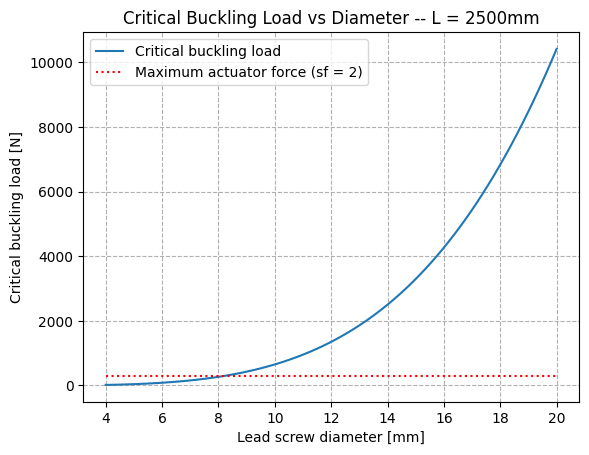

In [40]:
# Lead screw data  
diameters = np.linspace(4,20,80) # in [mm]
f_c = 4 # dual side - dual bearing support

P_crit = np.zeros(len(diameters))

for i in range(len(diameters)) : 
    # moment of inertia of the cross-section of the screw (considering a circular cross section) [mm^4] 
    I = np.pi * diameters[i]**4 /64 
    # crititical buckling load 
    P_crit[i] = np.pi**2 * E * 1000 * I / screw_length**2  * f_c

fig, ax = plt.subplots()
l1, = ax.plot(diameters,P_crit, label = "Critical buckling load")
l2, = ax.plot([diameters.min(), diameters.max()],[F_max,F_max], c= 'red', linestyle = 'dotted', label = "Maximum actuator force (sf = 2)")
ax.grid(linestyle = "--")
ax.set_title("Critical Buckling Load vs Diameter -- L = 2500mm")
ax.set_xlabel("Lead screw diameter [mm]")
ax.set_ylabel("Critical buckling load [N]")
ax.legend(handles = [l1,l2])

plt.show()

## Compression Study 

In [ ]:
diameters = np.linspace(1,15,80) # in [mm]
sigma = np.zeros(len(diameters))

for i in range(len(diameters)): 
    # nominal cross-sectional area of the cylinder in [mm^2]
    A_0  = np.pi * diameters[i]
    # compression stress in [MPa]
    sigma[i] = F_max / A_0 

fig, ax = plt.subplots()
l1, = ax.plot(diameters,sigma, label = "Compressive stress")
l2, = ax.plot([diameters.min(), diameters.max()],[sigma_comp_max,sigma_comp_max], c= 'red', linestyle = 'dotted', label = "Compressive strength")
ax.grid(linestyle = "--")
ax.set_title("Compressive stress vs Diameter")
ax.set_xlabel("Lead screw diameter [mm]")
ax.set_ylabel("Compressive stress [MPa]")
ax.legend(handles = [l1,l2])

plt.show()



## Motor torque
A useful guide on lead screws can be found [here](http://www.emc-technology-center.com/en/images/m_element/bsd/pdfs/ts_select.pdf).  
Thread calculations require the  major thread diameter. We also, silently, used this diameter in the buckling and compression calculations  

In [47]:
# For moment of inertia calculations, we consider the pitch diameter as the cylynder diameter, since it is the "average" of D_major and D_minor
linear_acc = feed_required/60/ 0.01  # max linear acceleration such that the rise time (from 0 to max speed) of the system is 0.001 sec -- in [m/s^2]
rotational_acc = linear_acc / (lead/1000) # max rotational acceleration -- in rot/sec^2
screw_volume = screw_length/1000 * (D_pitch/1000)**2/4 * np.pi # all units converted to SI
screw_density = 7.8 * 1000 # in [kg/m^3] 
screw_mass = screw_density * screw_volume 
I_rot = 0.5 * screw_mass * (D_pitch/1000)**2/4 # rotational moment of inertia, all units converted to SI
acc_torque = I_rot * rotational_acc 



thread_eff = 0 # in case the manufactured dirctly provide the thread efficiency

check_diameters =False 
if(check_diameters == True): 
    diameters = np.linspace(1,15,80)
    T_motor = np.zeros(len(diameters))
    miu = 0.11 # friction coefficient for movement between lubricated steels 
    rho = np.arctan(miu*1.07)

    for i in range(len(diameters)): 
        alpha = np.arctan(lead/diameters[i]/np.pi) # helical angle of the thread
        
        if(thread_eff != 0): 
            n = thread_eff
        else : 
            n = np.tan(alpha)/np.tan(alpha + rho) 
        T_motor[i] = F_max * lead / 2000 / np.pi / n 


    fig, ax = plt.subplots()
    l1, = ax.plot(diameters,T_motor, label = "Motor torque")
    # l2, = ax.plot([diameters.min(), diameters.max()],[sigma_comp_max,sigma_comp_max], c= 'red', linestyle = 'dotted', label = "Compressive strength")
    ax.grid(linestyle = "--")
    ax.set_title("Motor torque vs Diameter")
    ax.set_xlabel("Lead screw diameter [mm]")
    ax.set_ylabel("Motor torque [Nm]")
    # ax.legend(handles = [l1,l2])
    plt.show()

else : 
    miu = 0.11 # friction coefficient for movement between lubricated steels 
    rho = np.arctan(miu*1.07)
    alpha = np.arctan(lead/D_pitch/np.pi) # helical angle of the thread
    if(thread_eff != 0): 
        n = thread_eff
    else : 
        n = np.tan(alpha)/np.tan(alpha + rho) 
    T_motor = F_max * lead / 2000 / np.pi / n + acc_torque
    print("Torque required from the motor : %lf [Nm]"%T_motor)



Torque required from the motor : 2.838185 [Nm]
